In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
# TODO: Online w/ no initialization
# TODO: Average percentage of historical data that was used
# TODO: N really large, alpha = 0, online (Christina) algorithm should try and sample suboptimal arm at least once? 
# which would penalize the regret - not showing up.

In [63]:
# initialize params
seed = 294

num_iters = 50
T = 1000  # time horizon
n = 200   # num historical samples
delta = 0.1
alpha = 0 # percentage of time to pull arm 0
mean_arms = [.5, .5-delta]  # note: arm 0 always better
n_arms = len(mean_arms)

In [64]:
np.random.seed(seed)
regret_data = []

def generate_dataset(n, alpha):
    """ generate historical samples """
    dataset = {'0': [], '1': []}
    for _ in range(int(alpha*n)):
        dataset['0'].append(np.random.binomial(p=mean_arms[0], n=1))
    for _ in range(n - int(alpha*n)):
        dataset['1'].append(np.random.binomial(p=mean_arms[1], n=1))
    return dataset

def conf_r(t, n_pulls):
    """ compute confidence radius """
    return np.sqrt(2*np.log(1+t) / n_pulls)
    
online_use_all_data_count = 0.0
online_data_use_percentage = []

# simple algorithm (Thorsten 2012)
# basic UCB: no historical data
# online algorithm: Christina's

for i in range(num_iters):
    dataset = generate_dataset(n, alpha)
#     print(f'Dataset: {dataset}')

    # initialize counters
    online_data_index   = np.asarray([0,0])
    online_regret_index = 0
    
    regret = {}
    mean   = {}
    select = {}
    
    for algo in ['simple', 'no_history', 'online']:
        regret[algo] = 0
        mean[algo]   = np.asarray([0.0, 0.0])
        select[algo] = np.asarray([0, 0])
    
    mean['simple']   = np.asarray([max(0.0, np.mean(dataset['0'])), max(0.0, np.mean(dataset['1']))])
    select['simple'] = np.asarray([len(dataset['0']), len(dataset['1'])])
#     print(f'Starting estimates, simple: {simple_mean}, {simple_select}')
    
    for t in range(T+n):
        for algo in ['simple', 'no_history', 'online']:
#             if algo in ['simple', 'no_history']:
#                 if t >= T: continue
#             elif algo == 'online':
#                 if online_regret_index >= T: continue
#             else: raise NotImplementedError
                
            
            # -----------------------------------
            # pick arm to pull
            # -----------------------------------
            if algo == 'online':
                ucb = np.asarray([mean[algo][arm] + conf_r(online_regret_index+1, select[algo][arm]) \
                                  if select[algo][arm] > 0 else np.inf for arm in range(n_arms)])
            else:
                # note that simple and no_history are identical except for initialization of 'mean' and 'select'
                ucb = np.asarray([mean[algo][arm] + conf_r(t, select[algo][arm]) \
                                  if select[algo][arm] > 0 else np.inf for arm in range(n_arms)])
                
            arm = np.argmax(ucb)
            select[algo][arm] += 1
            
            if algo == 'online':
                # if we haven't used all offline samples of the chosen arm
                if online_data_index[arm] < len(dataset[str(arm)]):
                    obs = dataset[str(arm)][online_data_index[arm]]
                    mean[algo][arm] = (mean[algo][arm] * select[algo][arm] + obs) / (select[algo][arm]+1)
                    online_data_index[arm] += 1
                    continue
                # if we HAVE used all offline samples of the chosen arm
                else:
                    online_regret_index += 1
            
            # -----------------------------------
            # get observation and record
            # -----------------------------------
            regret[algo] += mean_arms[0] - mean_arms[arm]
            regret_data.append({'Algo': algo, 'Iter': i, 't': t, 'Regret': regret[algo]})
            obs = np.random.binomial(p=mean_arms[arm], n=1)
            mean[algo][arm] = (mean[algo][arm]*select[algo][arm] + obs) / (select[algo][arm]+1)

            
    # meta trackers on behavior of online algorithm
    if online_data_index[0] == len(dataset['0']) and online_data_index[1] == len(dataset['1']):
        online_use_all_data_count += 1
    
    online_data_use_percentage.append((online_data_index[0] + online_data_index[1]) / n)

print('----------------------------')
print('Stats from online algorithm')
print(f'  # pulls of each arm in historical data:     {online_data_index}')
print(f'  Percentage of trials entire dataset used:   {100 * online_use_all_data_count / num_iters}')
print(f'  Average percentage of historical data used: {100*np.mean(online_data_use_percentage):.2f}')

----------------------------
Stats from online algorithm
  # pulls of each arm in historical data:     [  0 200]
  Percentage of trials entire dataset used:   86.0
  Average percentage of historical data used: 98.61


Text(0.5, 1.0, 'n = 200, delta = 0.1, alpha = 1')

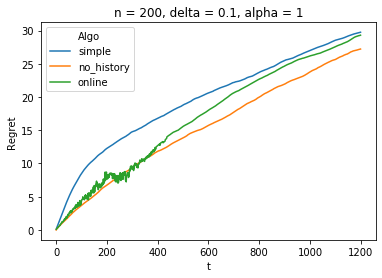

In [60]:
df = pd.DataFrame(regret_data)

p = sns.lineplot(data = df, x="t", y="Regret", hue="Algo", ci=None) #, ci="sd")
p.set_title(f"n = {n}, delta = {delta}, alpha = {alpha}") 
